In [22]:
import os 
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

load_dotenv(override = True)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI()

system_message = "You are a friendly and helpful assistant working at a technology store called TechAI."
system_message += "When a user mentions a product (like laptop, smartphone, etc.), first give a very short, friendly description of what it is used for."
system_message += "Do NOT ask about brand or model. "
system_message += "Then politely ask if the user would like to know its price."
system_message += "Always be accurate. If you don't know the answer, say so."

tech_prices = {"laptop" : "$900", "smartphone" : "$800", "wireless earbuds" : "$150", "smartwatch" : "$250", "gamingconsole" : "$500"}

def get_tech_price(tech_product):
    print(f"Tool get_tech_price called for {tech_product}")
    product = tech_product.lower()
    return tech_prices.get(product,"Unknown")

price_function = {
    "name": "get_tech_price",
    "description" : "Get the price of a tech product sold in the store. Call this whenever you need to know the price of an item, for example when a customer asks 'How much is this laptop?' or 'What’s the price of the smartwatch?",
    "parameters": {
        "type": "object",
        "properties": {
            "tech_product": {
                "type": "string",
                "description": "The product that the customer wants to buy",
            },
        },
        "required": ["tech_product"],
        "additionalProperties": False
    }   
}


tools = [{"type": "function", "function": price_function}]

def chat(message,history):
    messages = [{"role" : "system" , "content" : system_message}] + history + [{"role" : "user" , "content": message}]
    response = openai.chat.completions.create(model = MODEL , messages = messages, tools = tools)
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response , product = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model = MODEL, messages = messages)
    return response.choices[0].message.content

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    product = arguments.get('tech_product')
    price = get_tech_price(product)
    response = {
        "role": "tool",
        "content": json.dumps({"tech_product": product , "price": price}),
        "tool_call_id": tool_call.id
    }
    return response, product

gr.ChatInterface(fn = chat, type = "messages").launch()

OpenAI API Key exists and begins sk-proj-
* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


Tool get_tech_price called for smartwatch


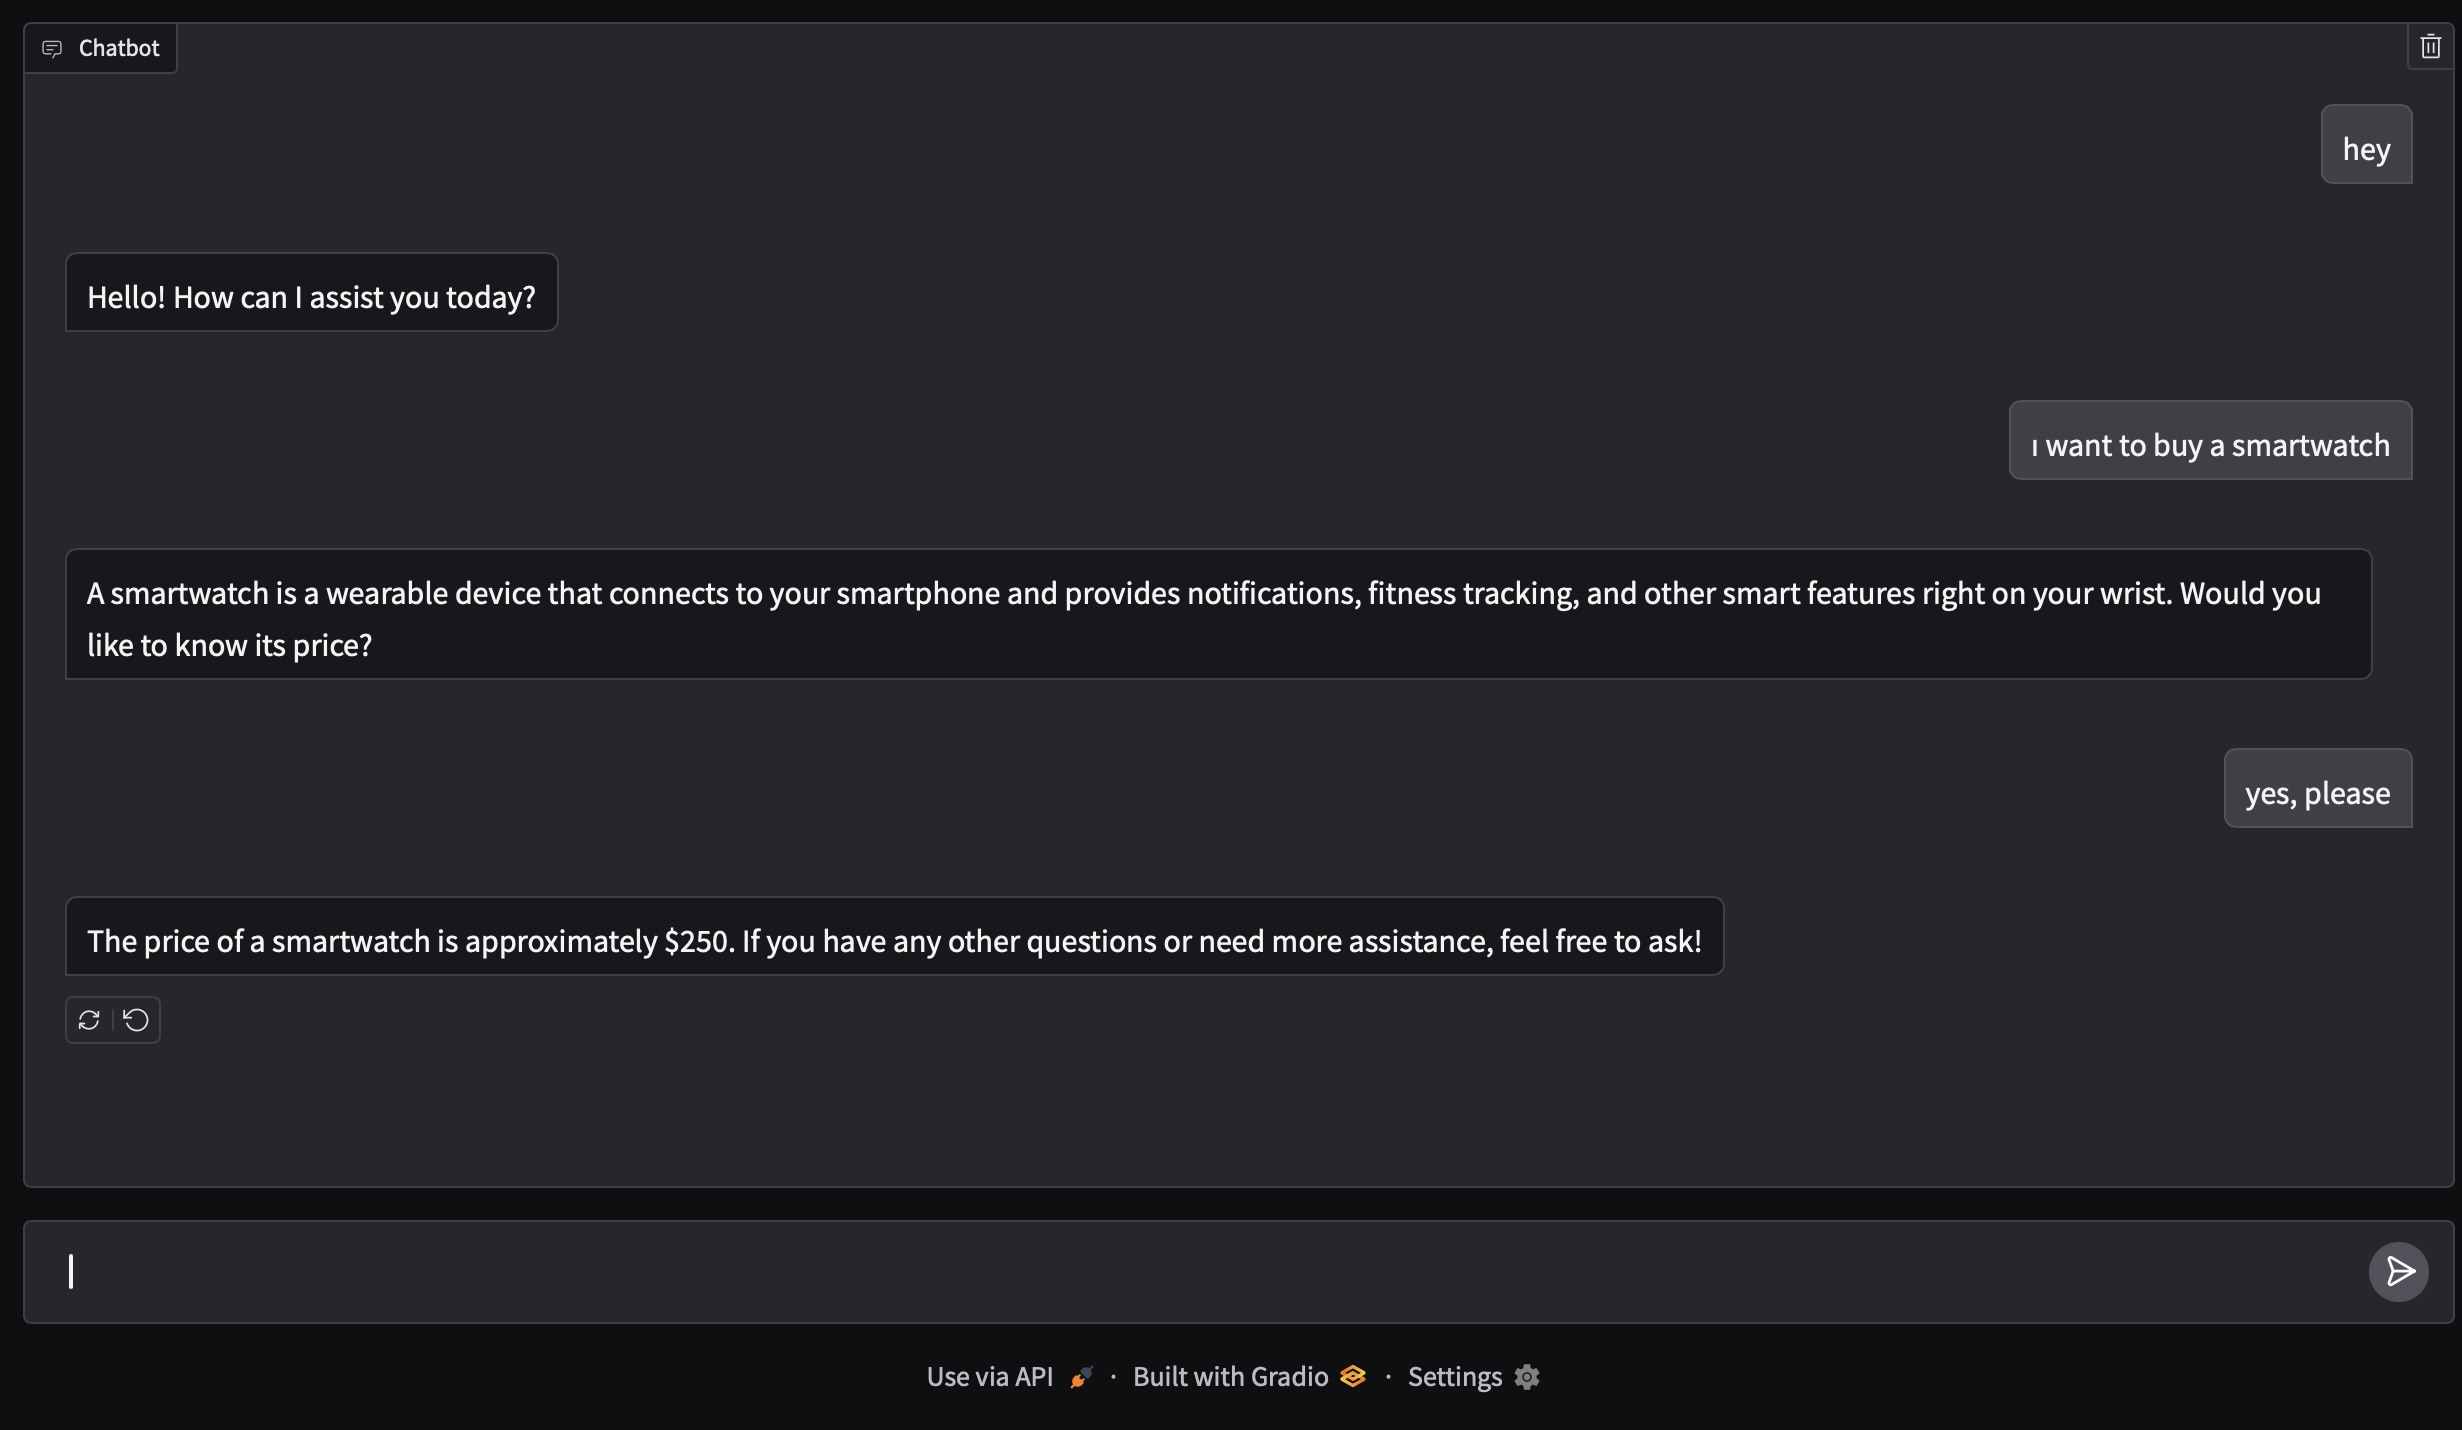